In [1]:
# Import standard libraries
from importlib import reload
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import sparse
import scipy.stats as ss
import csv
import pandas as pd
import networkx as nx
import community
import pickle
from collections import defaultdict
import operator
from scipy.sparse import csr_matrix
import itertools
import os.path
import math
import pybedtools
import time
from tqdm import tqdm

# Custom libraries
import prelim_analysis as pa
import prototype_utils as pu

In [2]:
# Reload modules in case of modifications
reload(pa)
reload(pu)

<module 'prototype_utils' from '/home/louiscam/projects/gpcr/code/preliminary_analysis/old/prototype_utils.py'>

# Data directories

In [3]:
# Directory of adhesome data
dir_adhesome = '/home/louiscam/projects/gpcr/data/adhesome_data/'
# Directory of genome data
dir_genome = '/home/louiscam/projects/gpcr/data/genome_data/'
# Directory of processed HiC
dir_processed_hic = '/home/louiscam/projects/gpcr/save/processed_hic_data_dir/'
# Directory for storing preliminary results
prelim_results_dir = '/home/louiscam/projects/gpcr/save/prelim_results_dir/'

In [4]:
# Specify directories and relevant information
cell_type = 'IMR90'
resol_str = '250kb'
resol = 250000
quality = 'MAPQGE30'

# Load adhesome data

In [5]:
adhesome_components_filename = dir_adhesome+'components.csv'
df_components = pa.load_adhesome_data(adhesome_components_filename)
# Print information
print('Number of components: '+str(len(df_components)))
print('Number of intrinsic components: '+str(len(df_components[df_components['FA']=='Intrinsic Proteins'])))
print('Number of associated components: '+str(len(df_components[df_components['FA']=='Associated Proteins'])))
df_components.head()

Number of components: 232
Number of intrinsic components: 150
Number of associated components: 82


,geneSymbol,geneID,proteinName,swisprotID,synonyms,functionalCategory,FA
0,ACTN1,87,Actinin,P12814,alpha-actinin,Actin regulation,Intrinsic Proteins
1,CFL1,1072,cofilin,P23528,CFL,Actin regulation,Intrinsic Proteins
2,CORO1B,57175,coronin 1B,Q9BR76,coronin-2,Actin regulation,Intrinsic Proteins
3,CTTN,2017,Cortactin,Q14247,"EMS1, Amplaxin",Actin regulation,Intrinsic Proteins
4,FLNA,2316,Filamin,P21333,"endothelial actin-binding protein, ABP-280, al...",Actin regulation,Intrinsic Proteins


In [6]:
# List of intrinsic components
intrinsic_comps = np.sort(df_components[df_components['FA']=='Intrinsic Proteins']['geneSymbol'].values)
print(intrinsic_comps[:5])
# List of associated components
associated_comps = np.sort(df_components[df_components['FA']=='Associated Proteins']['geneSymbol'].values)

['ABL1' 'ACTB' 'ACTN1' 'AGAP2' 'ARHGAP24']


# Position of genes on hg19 genome

In [7]:
# Path to gene locations and gene names files
gene_locations_filename = dir_genome+'chrom_hg19.loc_canonical'
gene_id_filename = dir_genome+'chrom_hg19.name'
df_loc = pa.get_gene_locations(gene_locations_filename, gene_id_filename)
print(len(df_loc))
df_loc.head()

25959


,transcript,geneSymbol,#chrom,chromStart,chromEnd,clusterId,protein
30786,uc021ree.1,7SK,chr12,114942680,114942992,7071,uc021ree.1
15095,uc002qsd.4,A1BG,chr19,58858171,58864865,15924,uc002qsd.4
14204,uc002qsg.3,A1BG-AS1,chr19,58863335,58866549,15925,uc002qsg.3
3436,uc001jjj.3,A1CF,chr10,52559168,52645435,3274,uc001jjj.3
6250,uc001qvk.1,A2M,chr12,9220303,9268558,6062,uc001qvk.1


# Location of adhesome genes

In [8]:
# Merge adhesome proteins dataframe with gene location dataframe
adhesome_loc_df = pa.get_adhesome_genes_location(df_components, df_loc)
print(len(adhesome_loc_df))
adhesome_loc_df.head()

Adhesome genes absent from UCSC genes: ['JUB', 'MSN', 'ARHGEF6', 'DDEF1', 'SH3KBP1', 'FLNA', 'SMPX', 'GRLF1', 'PPP2CA', 'ITGAW']
222


,gene,chrom,genoStart,genoEnd,geneLength
0,ACTN1,chr14,69340839,69446083,105244
1,CFL1,chr11,65622284,65626101,3817
2,CORO1B,chr11,67205517,67210983,5466
3,CTTN,chr11,70244611,70282690,38079
4,KEAP1,chr19,10596795,10614054,17259


In [9]:
# Specify start locus and end locus
adhesome_loc_df = pa.get_adhesome_genes_loci(adhesome_loc_df, resol)
adhesome_loc_df.head()

,gene,chrom,loci,genoStart,genoEnd,geneLength,startLocus_id,startLocus,startLocus_coverage,endLocus_id,endLocus,endLocus_coverage
0,ACTN1,chr14,278,69340839,69446083,105244,278,69500000,0.420976,278,69500000,0.420976
1,CFL1,chr11,263,65622284,65626101,3817,263,65750000,0.015268,263,65750000,0.015268
2,CORO1B,chr11,269,67205517,67210983,5466,269,67250000,0.021864,269,67250000,0.021864
3,CTTN,chr11,281,70244611,70282690,38079,281,70250000,0.021556,282,70500000,0.130760
3,CTTN,chr11,282,70244611,70282690,38079,281,70250000,0.021556,282,70500000,0.130760


# Create matrix of adhesome gene Hi-C contacts

In [10]:
# Add column specifying chromosome number as an int
adhesome_chr_loci = adhesome_loc_df[['gene','chrom','loci']]
adhesome_chr_loci['chrom_int'] = adhesome_chr_loci['chrom'].str.split('chr').str[1].astype(int)

In [11]:
# Select loci information of all adhesome genes (and sort by chromosome and locus)
adhesome_chr_loci = adhesome_chr_loci.sort_values(['chrom_int','loci'])
adhesome_chr_loci.head()

,gene,chrom,loci,chrom_int
34,FBLIM1,chr1,65,1
97,ASAP3,chr1,96,1
173,SLC9A1,chr1,110,1
158,FABP3,chr1,128,1
139,MACF1,chr1,159,1


In [12]:
# List of adhesome loci IDs
gene_list = np.array(adhesome_chr_loci.gene.drop_duplicates(keep='first'))
# Create empty dataframe indexed by loci ID
gene_contacts_df = pd.DataFrame(0, index=gene_list, columns=gene_list)

In [13]:
# Loop over all chromosome pairs and fill gene_contacts_df
chr_list = np.arange(1,23,1)
chr_pairs = list(itertools.combinations(chr_list, 2))
for pair in tqdm(chr_pairs):
    time.sleep(.01)
    chr1, chr2 = pair

    # Restrict adhesome dataframe to chr1 and chr2
    adhesome_chr1_df = adhesome_chr_loci.loc[adhesome_chr_loci['chrom']=='chr'+str(chr1)]
    adhesome_genes_chr1 = np.unique(adhesome_chr1_df['gene'])
    adhesome_chr2_df = adhesome_chr_loci.loc[adhesome_chr_loci['chrom']=='chr'+str(chr2)]
    adhesome_genes_chr2 = np.unique(adhesome_chr2_df['gene'])

    # Load HiC data for this chromosome pair
    processed_hic_filename = 'hic_'+'chr'+str(chr1)+'_'+'chr'+str(chr2)+'_norm1_filter3'+'.pkl'
    hic_chpair_df = pickle.load(open(dir_processed_hic+processed_hic_filename, 'rb'))

    # Fill in corresponding submatrix of gene_contacts_df by sum of Hi-C contacts across all gene loci
    gene_pairs = itertools.product(adhesome_genes_chr1,adhesome_genes_chr2)
    for gene1, gene2 in gene_pairs:
        gene1_loci = np.array(adhesome_chr1_df[adhesome_chr1_df['gene']==gene1]['loci']*resol)
        gene2_loci = np.array(adhesome_chr2_df[adhesome_chr2_df['gene']==gene2]['loci']*resol)
        gene_contacts_df.loc[gene1, gene2] = hic_chpair_df.loc[gene1_loci,gene2_loci].sum().sum()


100%|██████████| 231/231 [00:58<00:00,  3.96it/s]


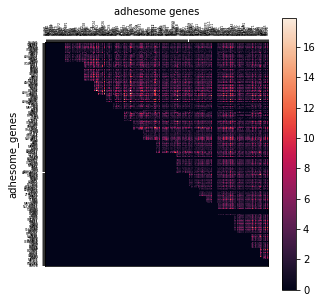

In [14]:
fig = plt.figure(figsize=(5,5))
ax = fig.add_subplot(111)
im = ax.imshow((gene_contacts_df), origin='upper', interpolation='none', cmap='rocket')
# Place ticks at the middle of every pixel
ax.set_xticks(np.arange(len(gene_list)))
ax.set_yticks(np.arange(len(gene_list)))
ax.set_ylim(len(gene_list)-0.5, -0.5)
# Use input dataframe row and column names as ticks
ax.set_xticklabels(gene_list, rotation=90, fontsize=3)
ax.set_yticklabels(gene_list, fontsize=3)
# Put x axis labels on top
ax.xaxis.set_label_position('top') 
ax.xaxis.set_ticks_position('top')
# Define axis name
ax.set_xlabel('adhesome genes')
ax.set_ylabel('adhesome_genes')
# Add colorbar
fig.colorbar(im)
#plt.savefig('hic_contacts_adhesome_genes.pdf', format='pdf')
plt.show()

# Load adhesome network adjacency matrix

In [15]:
np.unique(df_interactions['Type'])

NameError: name 'df_interactions' is not defined

In [214]:
df_interactions.sort_values(by=['Source','Target']).head()

,Source,Target,Effect,Type,PMID,data_source
798,ABI1,ABL1,+,activation,12591740,adhesome.org
2869,ABI1,ABL1,0,binding,18328268,axel_ppi
2870,ABI1,ABL1,0,binding,21320496,axel_ppi
2871,ABI1,ABL1,0,binding,17101133,axel_ppi
2872,ABI1,ABL1,0,binding,11163214,axel_ppi


(array([1370.,    0.,    0.,    0.,    0., 4124.,    0.,    0.,    0.,
        1048.]),
 array([0. , 0.2, 0.4, 0.6, 0.8, 1. , 1.2, 1.4, 1.6, 1.8, 2. ]),
 <a list of 10 Patch objects>)

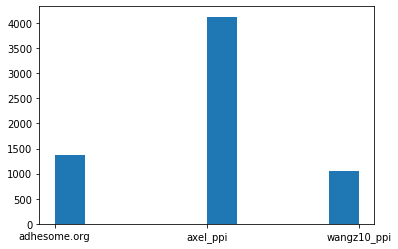

In [223]:
plt.hist(df_interactions['data_source'])

6
6


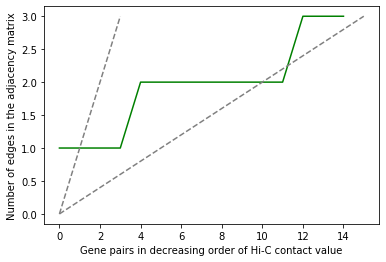

In [211]:
inter_type = 'unknown'

# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)
df_interactions['Type'] = df_interactions['Type'].str.lower().str.replace('_reaction','')

# Remove missing genes from node list
missing_genes = ['PPP2CA', 'FLNA', 'MSN', 'GRLF1', 'DDEF1', 'ARHGEF6', 'SMPX', 'SH3KBP1', 'JUB', 'ITGAW']
df_components1 = df_components[~df_components['geneSymbol'].isin(missing_genes)]
df_components1 = df_components1[~df_components1['geneSymbol'].isin(missing_genes)]
# Remove missing genes from edge list
df_interactions1 = df_interactions[~df_interactions['Source'].isin(missing_genes)]
df_interactions1 = df_interactions1[~df_interactions1['Target'].isin(missing_genes)]
# Remove non-genes from edge list (e.g. calcium)
df_interactions1 = df_interactions1[df_interactions1['Source'].isin(df_components1['geneSymbol'])]
df_interactions1 = df_interactions1[df_interactions1['Target'].isin(df_components1['geneSymbol'])]
# Only keep rows corresponding to the desired type of interaction
df_interactions1 = df_interactions1[df_interactions1['Type']==inter_type]
print(len(df_interactions1))
# Drop duplicate rows based on source and target protein
df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')
print(len(df_interactions1))

# Create dataframe with chromosome information for each adhesome gene
adhesome_chr = adhesome_chr_loci.drop_duplicates(subset='gene', keep='first')

# Add chromosome information for source and target genes
df_interactions1 = pd.merge(df_interactions1, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions1 = pd.merge(df_interactions1, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions1 = df_interactions1.drop(['gene_source','gene_target'], axis=1)
df_interactions1['same_chrom'] = df_interactions1['chrom_source']==df_interactions1['chrom_target']

# Remove edges between genes located on the same chromosomes
df_interactions1 = df_interactions1[df_interactions1['same_chrom']==False]

# Create networkX adhesome network without node attributes
adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])
# Dictionary of node attributes
node_attributes = {
    df_components1['geneSymbol'].iloc[i]: {'Gene ID': df_components1['geneID'].iloc[i],
                                         'Protein name': df_components1['proteinName'].iloc[i],
                                         'Swiss-Prot ID': df_components1['swisprotID'].iloc[i],
                                         'Synonyms': df_components1['synonyms'].iloc[i],
                                         'Functional Category': df_components1['functionalCategory'].iloc[i],
                                         'FA': df_components1['FA'].iloc[i]
                                     } 
                   for i in range(len(df_components1))

}
# Add node attributes to networkx graph
nx.set_node_attributes(adhesome_network, node_attributes)

# Transform the gene Hi-C contact dataframe to (index, column, value format)
gene_contacts_full_df = gene_contacts_df+gene_contacts_df.transpose()
new_index = pd.MultiIndex.from_tuples(itertools.combinations(gene_contacts_full_df.index.tolist(), 2),
                                      names=["columns","index"])
gene_contacts_full_df1 = gene_contacts_full_df.stack().reindex(new_index).reset_index(name='hic_contact')

# Transform the adhesome network adjacency matrix to (index, column, value format)
adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),adhesome_network_df.index.tolist()),
                                      names=["columns","index"])
adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

# Join gene_contacts_full_df1 and adhesome_network_df1
combined_df = pd.merge(gene_contacts_full_df1, adhesome_network_df1, 
                       how='inner', on=['columns','index'])
combined_df = combined_df.sort_values(by='hic_contact', ascending=False)

# Plot ROC curve
combined_df = combined_df[combined_df['hic_contact']>-1]
plt.figure()
plt.plot(np.arange(len(combined_df)),np.cumsum(combined_df['edge']), color='green')
plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
plt.xlabel('Gene pairs in decreasing order of Hi-C contact value')
plt.ylabel('Number of edges in the adjacency matrix')
plt.show()

In [144]:
# Load interactions
interactions_filename = 'interactions.csv'
df_interactions = pd.read_csv(dir_adhesome+interactions_filename, sep = ',', header = 0)

In [75]:
# Remove missing genes from node list
missing_genes = ['PPP2CA', 'FLNA', 'MSN', 'GRLF1', 'DDEF1', 'ARHGEF6', 'SMPX', 'SH3KBP1', 'JUB', 'ITGAW']
df_components1 = df_components[~df_components['geneSymbol'].isin(missing_genes)]
df_components1 = df_components1[~df_components1['geneSymbol'].isin(missing_genes)]
# Remove missing genes from edge list
df_interactions1 = df_interactions[~df_interactions['Source'].isin(missing_genes)]
df_interactions1 = df_interactions1[~df_interactions1['Target'].isin(missing_genes)]
# Remove non-genes from edge list (e.g. calcium)
df_interactions1 = df_interactions1[df_interactions1['Source'].isin(df_components1['geneSymbol'])]
df_interactions1 = df_interactions1[df_interactions1['Target'].isin(df_components1['geneSymbol'])]
# Drop duplicate rows based on source and target protein
df_interactions1 = df_interactions1.drop_duplicates(subset=['Source','Target'], keep='first')

In [78]:
# Create dataframe with chromosome information for each adhesome gene
adhesome_chr = adhesome_chr_loci.drop_duplicates(subset='gene', keep='first')

In [79]:
# Add chromosome information for source and target genes
df_interactions1 = pd.merge(df_interactions1, adhesome_chr[['gene','chrom']].add_suffix('_source'), 
                       how='inner', left_on='Source', right_on='gene_source')
df_interactions1 = pd.merge(df_interactions1, adhesome_chr[['gene','chrom']].add_suffix('_target'), 
                       how='inner', left_on='Target', right_on='gene_target')
df_interactions1 = df_interactions1.drop(['gene_source','gene_target'], axis=1)
df_interactions1['same_chrom'] = df_interactions1['chrom_source']==df_interactions1['chrom_target']
print(len(df_interactions1))
df_interactions1.head(13)

2658


,Source,Target,Effect,Type,PMID,data_source,chrom_source,chrom_target,same_chrom
0,LPXN,GIT1,0,Binding,12674328,adhesome.org,chr11,chr17,False
1,PAK1,GIT1,0,Binding,12006652,adhesome.org,chr11,chr17,False
2,PLCG1,GIT1,0,Binding,16598076,adhesome.org,chr20,chr17,False
3,SRC,GIT1,+,Activation,14523024,adhesome.org,chr20,chr17,False
4,PTK2B,GIT1,0,Binding,12629171,axel_ppi,chr8,chr17,False
5,MAPK1,GIT1,0,Binding,15923189,adhesome.org,chr22,chr17,False
6,PTK2,GIT1,+,Activation,10938112,adhesome.org,chr8,chr17,False
7,PXN,GIT1,0,Binding,11448998,adhesome.org,chr12,chr17,False
8,GRB2,GIT1,0,Binding,21900206,axel_ppi,chr17,chr17,True
9,PTPRF,GIT1,0,Binding,12629171,axel_ppi,chr1,chr17,False


In [80]:
# Remove edges between genes located on the same chromosomes
df_interactions1 = df_interactions1[df_interactions1['same_chrom']==False]
print(len(df_interactions1))
df_interactions1.head(13)

2514


,Source,Target,Effect,Type,PMID,data_source,chrom_source,chrom_target,same_chrom
0,LPXN,GIT1,0,Binding,12674328,adhesome.org,chr11,chr17,False
1,PAK1,GIT1,0,Binding,12006652,adhesome.org,chr11,chr17,False
2,PLCG1,GIT1,0,Binding,16598076,adhesome.org,chr20,chr17,False
3,SRC,GIT1,+,Activation,14523024,adhesome.org,chr20,chr17,False
4,PTK2B,GIT1,0,Binding,12629171,axel_ppi,chr8,chr17,False
5,MAPK1,GIT1,0,Binding,15923189,adhesome.org,chr22,chr17,False
6,PTK2,GIT1,+,Activation,10938112,adhesome.org,chr8,chr17,False
7,PXN,GIT1,0,Binding,11448998,adhesome.org,chr12,chr17,False
9,PTPRF,GIT1,0,Binding,12629171,axel_ppi,chr1,chr17,False
10,PDPK1,GIT1,0,Binding,21900206,axel_ppi,chr16,chr17,False


In [81]:
# Create networkX adhesome network without node attributes
adhesome_network = nx.from_pandas_edgelist(df_interactions1, 'Source', 'Target', 
                                            ['Effect', 'Type', 'PMID', 'data_source'])
print('Number of interactions: '+str(len(adhesome_network.edges)))

Number of interactions: 1257


In [82]:
# Dictionary of node attributes
node_attributes = {
    df_components1['geneSymbol'].iloc[i]: {'Gene ID': df_components1['geneID'].iloc[i],
                                         'Protein name': df_components1['proteinName'].iloc[i],
                                         'Swiss-Prot ID': df_components1['swisprotID'].iloc[i],
                                         'Synonyms': df_components1['synonyms'].iloc[i],
                                         'Functional Category': df_components1['functionalCategory'].iloc[i],
                                         'FA': df_components1['FA'].iloc[i]
                                     } 
                   for i in range(len(df_components1))

}

In [83]:
# Add node attributes to networkx graph
nx.set_node_attributes(adhesome_network, node_attributes)

# ROC curve
We sort all pairs of genes based on their Hi-C contact values, and examine whether the corresponding gene pirs corresponds to an edge in the adhesome network. This allows us to plot an ROC-type curve, where the x-axis corresponds to the list of gene pairs, sorted in descending order of Hi-C contact, and the y-axis corresponds to the number top edges that are actually present in the adhesome network.

In [84]:
# Transform the gene Hi-C contact dataframe to (index, column, value format)
gene_contacts_full_df = gene_contacts_df+gene_contacts_df.transpose()
new_index = pd.MultiIndex.from_tuples(itertools.combinations(gene_contacts_full_df.index.tolist(), 2),
                                      names=["columns","index"])
gene_contacts_full_df1 = gene_contacts_full_df.stack().reindex(new_index).reset_index(name='hic_contact')

In [85]:
# Transform the adhesome network adjacency matrix to (index, column, value format)
adhesome_network_df = nx.to_pandas_adjacency(adhesome_network, dtype=int)
new_index = pd.MultiIndex.from_tuples(itertools.product(adhesome_network_df.index.tolist(),adhesome_network_df.index.tolist()),
                                      names=["columns","index"])
adhesome_network_df1 = adhesome_network_df.stack().reindex(new_index).reset_index(name='edge')

In [143]:
# Join gene_contacts_full_df1 and adhesome_network_df1
combined_df = pd.merge(gene_contacts_full_df1, adhesome_network_df1, 
                       how='inner', on=['columns','index'])
combined_df = combined_df.sort_values(by='hic_contact', ascending=False)
combined_df.head()

,columns,index,hic_contact,edge
8918,LPP,PTK2,17.902131,0
8885,LPP,PALLD,17.630129,0
9407,PALLD,PTK2,16.536330,0
10324,PDE4D,TIAM1,16.184708,0
10247,PDE4D,PTPRO,15.752584,0


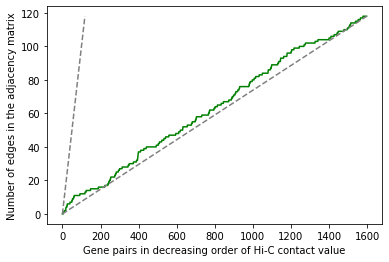

In [141]:
# Plot ROC curve
combined_df = combined_df[combined_df['hic_contact']>5]
plt.figure()
plt.plot(np.arange(len(combined_df)),np.cumsum(combined_df['edge']), color='green')
plt.plot([0,len(combined_df)],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
plt.plot([0,np.sum(combined_df['edge'])],[0,np.sum(combined_df['edge'])], color='grey', linestyle='dashed')
plt.xlabel('Gene pairs in decreasing order of Hi-C contact value')
plt.ylabel('Number of edges in the adjacency matrix')
plt.show()

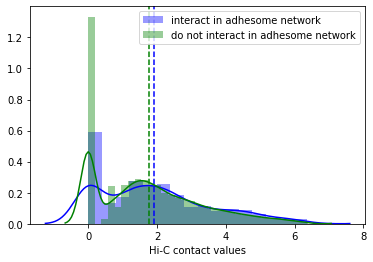

Mean of Hi-C contacts for gene pairs that interact in the adhesome network = 1.9239188087377854
Mean of Hi-C contacts for gene pairs that do not interact in the adhesome network = 1.769337308525597


In [133]:
# Compare distibution of Hi-C contact values between pairs that have versus do not have an edge in the adhesome network
plt.figure()
sns.distplot(combined_df[combined_df['edge']==1]['hic_contact'], color='blue', label='interact in adhesome network')
plt.axvline(x = np.mean(combined_df[combined_df['edge']==1]['hic_contact']), color='blue', linestyle='dashed')
sns.distplot(combined_df[combined_df['edge']==0]['hic_contact'], color='green', label='do not interact in adhesome network')
plt.axvline(x = np.mean(combined_df[combined_df['edge']==0]['hic_contact']), color='green', linestyle='dashed')
plt.xlabel('Hi-C contact values')
plt.legend(loc='upper right')
plt.show()
print('Mean of Hi-C contacts for gene pairs that interact in the adhesome network = '+
      str(np.mean(combined_df[combined_df['edge']==1]['hic_contact'])))
print('Mean of Hi-C contacts for gene pairs that do not interact in the adhesome network = '+
      str(np.mean(combined_df[combined_df['edge']==0]['hic_contact'])))

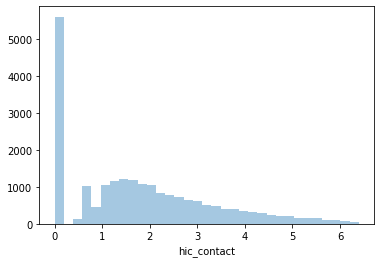

In [129]:
sns.distplot(combined_df['hic_contact'], kde=False)

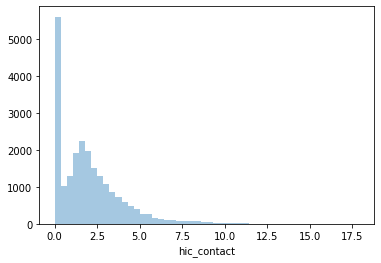

In [126]:
sns.distplot(combined_df['hic_contact'], kde=False)
